In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from numpy import mean
from numpy import var
import time
from sklearn.model_selection import cross_validate
import shap

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from math import sqrt
from sklearn.metrics import matthews_corrcoef

# 匯入資料

In [2]:
data=pd.read_csv("data-question/train.csv")
data.head()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,8773,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,2,3.0,11.0,3.0,7.0,2.0,0,0
1,6709,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,9,1.0,10.0,0.0,8.0,2.0,0,0
2,1463,9,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,8,1.0,10.0,0.0,14.0,2.0,0,0
3,4095,2,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,2,5.0,10.0,0.0,7.0,2.0,0,0
4,3346,0,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,2,1.0,1.0,0.0,7.0,2.0,0,0


# 確認資料

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8100 non-null   int64  
 1   Administrative           8100 non-null   int64  
 2   Administrative_Duration  8100 non-null   float64
 3   Informational            8100 non-null   int64  
 4   Informational_Duration   8100 non-null   float64
 5   ProductRelated           8100 non-null   int64  
 6   ProductRelated_Duration  8099 non-null   float64
 7   BounceRates              8100 non-null   float64
 8   ExitRates                8100 non-null   float64
 9   PageValues               8100 non-null   float64
 10  SpecialDay               8100 non-null   float64
 11  Month                    8100 non-null   int64  
 12  OperatingSystems         8099 non-null   float64
 13  Browser                  8099 non-null   float64
 14  Region                  

In [4]:
#尋找相關性
#使用corr()計算每一對屬性之間的標準相關性係數
corr_matrix = data.corr()

#查看每一個屬性與是否訂房之間的相關性有多大
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.499500
ProductRelated             0.149177
Administrative             0.142747
Month                      0.127990
Administrative_Duration    0.095692
Informational              0.091298
Informational_Duration     0.068661
Weekend                    0.003893
ID                        -0.001342
ProductRelated_Duration   -0.005530
Region                    -0.010402
Browser                   -0.018902
BounceRates               -0.050082
OperatingSystems          -0.070977
SpecialDay                -0.076422
TrafficType               -0.088077
VisitorType               -0.111334
ExitRates                 -0.207791
Name: Revenue, dtype: float64

## 確認遺失值

In [5]:
data.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    1
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           1
Browser                    1
Region                     1
TrafficType                1
VisitorType                1
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
#查看其他欄位的數值屬性摘要
data.describe()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8.099000e+03,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000,8100.000000,8100.000000
mean,4500.375432,2.309877,80.926113,0.498025,32.884300,31.787160,8.311549e+04,0.020345,0.042699,5.744406,0.060469,4.806049,2.236202,7.782813,2.685146,7.669342,1.847389,0.253210,0.157654
std,2601.276244,3.311618,180.089694,1.258087,135.210888,44.961092,6.359096e+06,0.131949,0.047943,17.940567,0.197809,3.175648,1.654721,3.309934,2.668688,3.907496,0.377722,1.188062,0.364439
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2237.750000,0.000000,0.000000,0.000000,0.000000,7.000000,1.837708e+02,0.000000,0.014286,0.000000,0.000000,2.000000,1.000000,3.000000,0.000000,4.000000,2.000000,0.000000,0.000000
50%,4504.500000,1.000000,7.000000,0.000000,0.000000,18.000000,5.988738e+02,0.003202,0.025129,0.000000,0.000000,4.000000,1.000000,10.000000,2.000000,8.000000,2.000000,0.000000,0.000000
75%,6760.250000,4.000000,91.988636,0.000000,0.000000,38.000000,1.462142e+03,0.016925,0.050000,0.000000,0.000000,8.000000,3.000000,10.000000,6.000000,12.000000,2.000000,0.000000,0.000000
max,8999.000000,27.000000,3398.750000,24.000000,2549.375000,705.000000,5.634924e+08,0.200000,0.200000,287.953793,1.000000,13.000000,7.000000,12.000000,8.000000,19.000000,2.000000,100.000000,1.000000


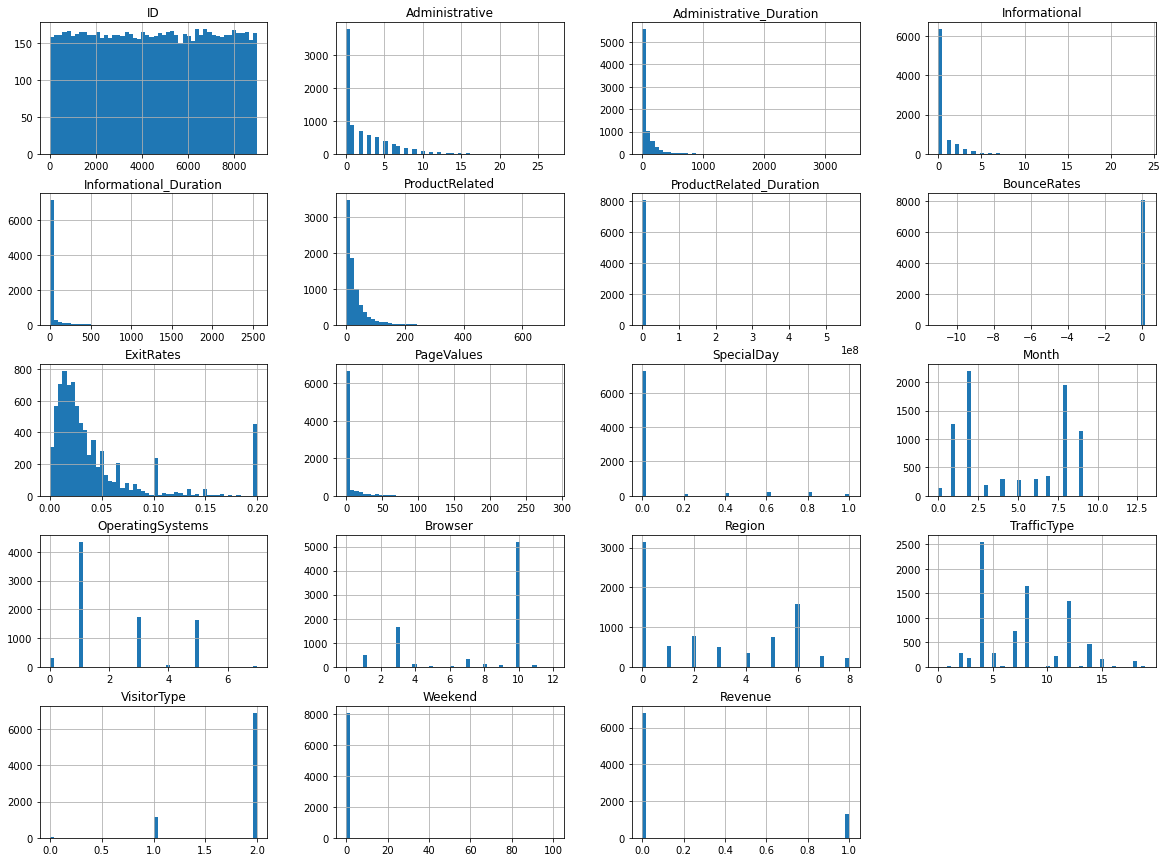

In [7]:
#將每一數值屬性畫出直方圖
%matplotlib inline
data.hist(bins=50, figsize=(20,15))
plt.show()

# 處理遺失值

In [8]:
df = data.dropna(axis=0)
## 確認遺失值
df.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

# Split the Features (X) and Target (Y)

In [9]:
y = df['Revenue'].values
X = df.drop(['ID','Revenue'],axis=1)

Counter({0: 6820, 1: 1277})


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


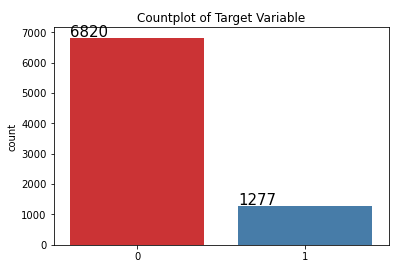

In [10]:
# See the relationshipt between Classes
from collections import Counter
import seaborn as sns
counter = Counter(y)
print(counter)
digit_count = sns.countplot(y,palette="Set1")
plt.title("Countplot of Target Variable")

for p in digit_count.patches:
    digit_count.annotate(f'\n{p.get_height()}', (p.get_x(), p.get_height()+50), color='black', size=15)
plt.show()

可由上圖看到資料為不平衡資料 18.72%

In [11]:
def get_data(c):
    TN = c[0,0]
    FP = c[0,1]
    FN = c[1,0]
    TP = c[1,1]
    return TP, FP, FN, TN

def cohen_kappa(TP, FP, FN, TN):
    p_0 = (TN + TP) / (TN + FP + FN + TP)
    p_c = ((TN+FN)*(TN+FP) + (FN+TP)*(FP+TP)) / (TN + FP + FN + TP)**2
    kappa = (p_0 - p_c) / (1-p_c)
    return kappa
## cohen_kappa_score(y_pred, y_truth)

def mcc(TP, FP, FN, TN):
    numerator = (TP * TN) - (FP * FN)
    denominator = sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN))
    mcc = numerator / denominator
    return mcc
## matthews_corrcoef(y_truth, y_pred)

In [12]:
## 用於合併多餘類別項目
def new_month(value):
  if value == 1:
    return 1
  elif value == 2:
    return 2
  elif value == 8:
    return 3
  elif value == 9:
    return 4
  else:
    return 0

def new_OperatingSystems(value):
  if value == 1:
    return 1
  elif value == 3:
    return 2
  elif value == 5:
    return 3
  else:
    return 0

def new_browser(value):
  if value == 10:
    return 0
  elif value == 3:
    return 1
  else:
    return 2

def new_TrafficType(value):
  if value == 4:
    return 1
  elif value == 8:
    return 2
  elif value == 12:
    return 3
  elif value == 7:
    return 4
  elif value == 14:
    return 5
  elif value == 2:
    return 5
  elif value == 5:
    return 6
  elif value == 11:
    return 6
  elif value == 3:
    return 6
  else:
    return 0

## 分割訓練集 / 測試集 80/20

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Case 1 :不做資料前處理

In [14]:
xgbc =XGBClassifier()         
xgbc.fit(x_train , y_train)
xgbc.score(x_train, y_train), xgbc.score(x_test , y_test)

[05:45:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


(0.9936699089084453, 0.8851851851851852)

In [15]:
y_pred = xgbc.predict(x_test)
recall_test = recall_score(np.array(y_test), y_pred, average=None)
precision_test = precision_score(np.array(y_test), y_pred, average=None)
f1_score_test = f1_score(np.array(y_test), y_pred, average=None)
c=confusion_matrix(y_test,y_pred)
c

array([[1289,   60],
       [ 126,  145]], dtype=int64)

In [16]:
recall_test, precision_test,f1_score_test

(array([0.95552261, 0.53505535]),
 array([0.91095406, 0.70731707]),
 array([0.93270622, 0.6092437 ]))

In [17]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.8851851851851852

In [18]:
TP, FP, FN, TN = get_data(c)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5434614627051106, 0.5507360465234322)

 97%|=================== | 6261/6477 [00:17<00:00]       

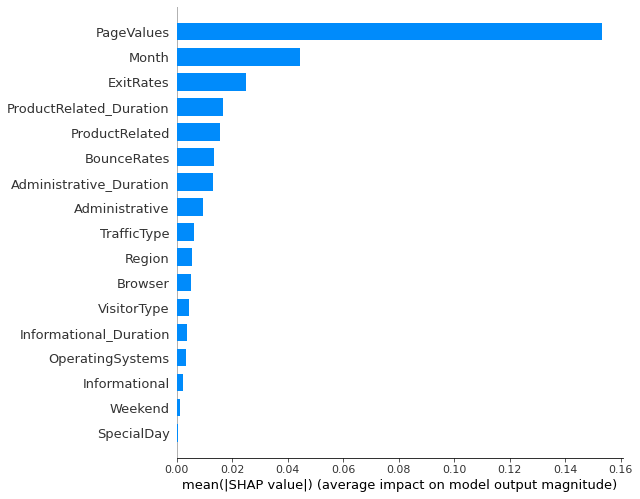

In [19]:
# 特徵重要程度
explainer = shap.TreeExplainer(xgbc,x_train, model_output='probability')
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train,plot_type="bar")

In [20]:
## 特徵重要程度占比
shap_value_0 = pd.DataFrame(shap_values)
shap_value_1_0 = abs(shap_value_0)
shap_value_col_1 = np.sum(shap_value_1_0 , axis = 0)/len(shap_values)
shap_value_col_1 = shap_value_col_1.sort_values()
p = shap_value_col_1/sum(shap_value_col_1)*100
p.sort_values(ascending=False)

8     47.418551
10    13.737964
7      7.770030
5      5.164457
4      4.806718
6      4.196754
1      4.032485
0      2.867653
14     1.969275
13     1.706412
12     1.549552
15     1.396531
3      1.182401
11     0.973131
2      0.687917
16     0.366023
9      0.174147
dtype: float64

# 特徵處理

## 類別型特徵處理
### 刪除異常值
在前面可以發現類別型特徵裡，Month多了13月、weekend多了100(一般只有0or1)

In [21]:
data2 = df[-df.Month.isin([13])]
data3 = data2[-data2.Weekend.isin([100])]
data3

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,8773,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,2,3.0,11.0,3.0,7.0,2.0,0,0
1,6709,0,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,9,1.0,10.0,0.0,8.0,2.0,0,0
2,1463,9,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,8,1.0,10.0,0.0,14.0,2.0,0,0
3,4095,2,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,2,5.0,10.0,0.0,7.0,2.0,0,0
4,3346,0,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,2,1.0,1.0,0.0,7.0,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,3758,0,0.000000,0,0.0,4,81.000000,0.000000,0.050000,0.000000,0.4,2,1.0,1.0,5.0,7.0,2.0,0,0
8096,4437,1,15.200000,2,62.6,84,4941.698611,0.017647,0.038706,0.000000,0.0,6,3.0,11.0,1.0,8.0,2.0,0,0
8097,7449,0,0.000000,0,0.0,25,701.883333,0.000000,0.023333,0.000000,0.0,6,1.0,10.0,0.0,4.0,2.0,0,0
8098,665,9,183.785714,1,90.0,95,3346.501984,0.002118,0.018656,5.932009,0.0,8,5.0,10.0,5.0,4.0,2.0,0,1


## 對類別型特徵做One-hot-encoding
Month、OperatingSystems、Browser、Region、TrafficType、VisitorType、Weekend

In [22]:
df_str = data3.astype({'Month':'category','OperatingSystems':'category','Browser':'category','Region':'category','TrafficType':'category','VisitorType':'category','Weekend':'category'})
df_str
df_dum = pd.get_dummies(df_str[['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']])

df_str.drop(['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend'], axis=1, inplace=True)

df_new = pd.concat([df_dum,df_str],axis=1)
df_new

,Month_0,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
0,0,0,1,0,0,0,0,0,0,0,...,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,0
1,0,0,0,0,0,0,0,0,0,1,...,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,0
2,0,0,0,0,0,0,0,0,1,0,...,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,0
3,0,0,1,0,0,0,0,0,0,0,...,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,0
4,0,0,1,0,0,0,0,0,0,0,...,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,0,0,1,0,0,0,0,0,0,0,...,0.000000,0,0.0,4,81.000000,0.000000,0.050000,0.000000,0.4,0
8096,0,0,0,0,0,0,1,0,0,0,...,15.200000,2,62.6,84,4941.698611,0.017647,0.038706,0.000000,0.0,0
8097,0,0,0,0,0,0,1,0,0,0,...,0.000000,0,0.0,25,701.883333,0.000000,0.023333,0.000000,0.0,0
8098,0,0,0,0,0,0,0,0,1,0,...,183.785714,1,90.0,95,3346.501984,0.002118,0.018656,5.932009,0.0,1


### Split x and y

In [23]:
y_ohe=df_new['Revenue'].values
X_ohe=df_new.drop(['ID','Revenue'],axis=1)

### 分割訓練集 / 測試集 80/20

In [24]:
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.2, random_state=1)

### 數值型特徵標準化
Administrative、Administrative_Duration、Informational、nformational_Duration、ProductRelated、ProductRelated_Duration、BounceRates 、ExitRates、PageValues、SpecialDay為連續型特徵，但區間過大，需先做標準化，以利於再做PCA

StandardScaler適用於本身服從常態分佈的數據，與本題不符  
MinMaxScaler適用於分布範圍較穩定的數據，亦與本題不符  
故採用RobustScaler適用於包含許多異常值的數據，可弱化Outlier的影響

In [25]:
rob_scaler = RobustScaler()
rob_data = x_train_ohe.copy()


rob_data['rob_scaled_Administrative'] = rob_scaler.fit_transform(rob_data['Administrative'].values.reshape(-1,1))
rob_data['rob_scaled_Administrative_Duration'] = rob_scaler.fit_transform(rob_data['Administrative_Duration'].values.reshape(-1,1))
rob_data['rob_scaled_Informational'] = rob_scaler.fit_transform(rob_data['Informational'].values.reshape(-1,1))
rob_data['rob_scaled_Informational_Duration'] = rob_scaler.fit_transform(rob_data['Informational_Duration'].values.reshape(-1,1))
rob_data['rob_scaled_ProductRelated'] = rob_scaler.fit_transform(rob_data['ProductRelated'].values.reshape(-1,1))
rob_data['rob_scaled_ProductRelated_Duration'] = rob_scaler.fit_transform(rob_data['ProductRelated_Duration'].values.reshape(-1,1))
rob_data['rob_scaled_BounceRates'] = rob_scaler.fit_transform(rob_data['BounceRates'].values.reshape(-1,1))
rob_data['rob_scaled_ExitRates'] = rob_scaler.fit_transform(rob_data['ExitRates'].values.reshape(-1,1))
rob_data['rob_scaled_PageValues'] = rob_scaler.fit_transform(rob_data['PageValues'].values.reshape(-1,1))
rob_data['rob_scaled_SpecialDay'] = rob_scaler.fit_transform(rob_data['SpecialDay'].values.reshape(-1,1))




rob_data.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.015596,0.157505,0.274707,0.020692,0.035825,0.034898,0.034744,0.045244,0.237492,0.143298,...,0.323695,0.797128,0.491198,31.904603,0.449087,79.421443,9.734188e-01,0.495705,5.654681,0.061674
std,0.123916,0.364304,0.446401,0.142361,0.185867,0.183536,0.183144,0.207855,0.425579,0.350404,...,0.820068,1.941321,1.248103,134.282300,1.437651,5480.885946,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-0.468797,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-0.326744,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.750000,0.923654,0.000000,0.000000,0.645161,0.673256,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.500000,36.992502,24.000000,2549.375000,22.161290,434293.175348,1.143863e+01,4.896553,287.953793,1.000000


# Case 2 : 做完資料處理 no PCA

In [26]:
xgbc_2 =XGBClassifier()         
xgbc_2.fit(rob_data , y_train_ohe)
xgbc_2.score(rob_data , y_train_ohe)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:45:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.993514515132798

In [27]:
rob_scaler = RobustScaler()
rob_data_test = x_test_ohe.copy()


rob_data_test['rob_scaled_Administrative'] = rob_scaler.fit_transform(rob_data_test['Administrative'].values.reshape(-1,1))
rob_data_test['rob_scaled_Administrative_Duration'] = rob_scaler.fit_transform(rob_data_test['Administrative_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_Informational'] = rob_scaler.fit_transform(rob_data_test['Informational'].values.reshape(-1,1))
rob_data_test['rob_scaled_Informational_Duration'] = rob_scaler.fit_transform(rob_data_test['Informational_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_ProductRelated'] = rob_scaler.fit_transform(rob_data_test['ProductRelated'].values.reshape(-1,1))
rob_data_test['rob_scaled_ProductRelated_Duration'] = rob_scaler.fit_transform(rob_data_test['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_BounceRates'] = rob_scaler.fit_transform(rob_data_test['BounceRates'].values.reshape(-1,1))
rob_data_test['rob_scaled_ExitRates'] = rob_scaler.fit_transform(rob_data_test['ExitRates'].values.reshape(-1,1))
rob_data_test['rob_scaled_PageValues'] = rob_scaler.fit_transform(rob_data_test['PageValues'].values.reshape(-1,1))
rob_data_test['rob_scaled_SpecialDay'] = rob_scaler.fit_transform(rob_data_test['SpecialDay'].values.reshape(-1,1))




rob_data_test.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.018530,0.151328,0.261272,0.034589,0.034589,0.035825,0.040148,0.038295,0.254478,0.130945,...,0.341723,0.819203,0.526868,36.904649,0.477002,0.484469,1.124925,0.499822,6.121047,0.055466
std,0.134899,0.358479,0.439464,0.182794,0.182794,0.185910,0.196367,0.191967,0.435702,0.337444,...,0.858906,2.025238,1.298849,139.024740,1.552211,1.554453,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.465863,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.316023,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.750000,0.913391,0.000000,0.000000,0.666667,0.683977,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.750000,25.976492,14.000000,1511.700000,22.300000,18.769177,11.845923,5.112624,261.491286,1.000000


In [28]:
y_pred_2 = xgbc_2.predict(rob_data_test)
recall_test_2 = recall_score(np.array(y_test_ohe), y_pred_2, average=None)
precision_test_2 = precision_score(np.array(y_test_ohe), y_pred_2, average=None)
f1_score_test_2 = f1_score(np.array(y_test_ohe), y_pred_2, average=None)
c2=confusion_matrix(y_test_ohe,y_pred_2)
c2

array([[1288,   51],
       [ 115,  165]], dtype=int64)

In [29]:
recall_test_2, precision_test_2,f1_score_test_2

(array([0.96191187, 0.58928571]),
 array([0.91803279, 0.76388889]),
 array([0.93946025, 0.66532258]))

In [30]:
accuracy_2 = accuracy_score(y_test_ohe,y_pred_2)
accuracy_2

0.897467572575664

In [31]:
TP, FP, FN, TN = get_data(c2)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.6059695277862489, 0.6130852986739118)

 98%|===================| 6345/6476 [00:18<00:00]        

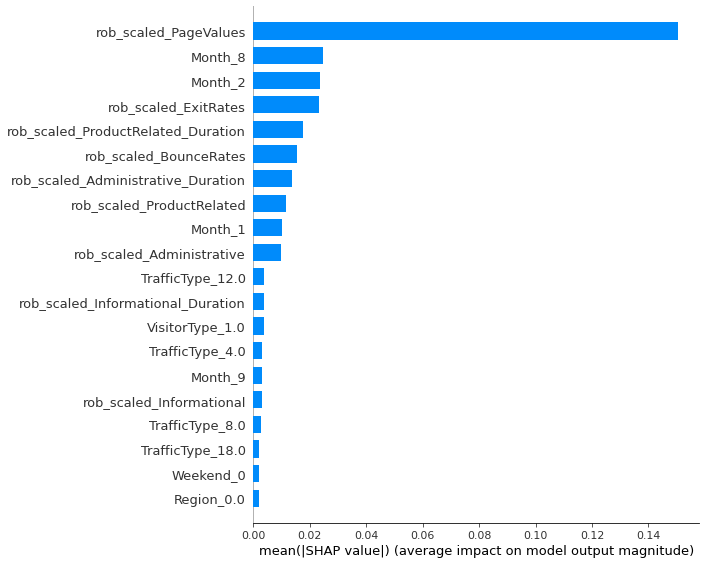

In [32]:
# 特徵重要程度
explainer_1 = shap.TreeExplainer(xgbc_2,rob_data, model_output='probability')
shap_values_1 = explainer_1.shap_values(rob_data)
shap.summary_plot(shap_values_1,rob_data,plot_type="bar")

In [33]:
shap_value_2 = pd.DataFrame(shap_values_1)
shap_value_1_0 = abs(shap_value_2)
shap_value_col_1 = np.sum(shap_value_1_0 , axis = 0)/len(shap_values_1)
shap_value_col_1 = shap_value_col_1.sort_values()
p = shap_value_col_1/sum(shap_value_col_1)*100
p.sort_values(ascending=False)

73    41.722780
8      6.824459
2      6.606756
72     6.508299
70     4.896873
        ...    
53     0.000000
59     0.000000
12     0.000000
56     0.000000
18     0.000000
Length: 75, dtype: float64

# Case8: 做完資料處理 + Imbalanced data處理

In [34]:
# summarize class distribution
counter = Counter(y_train_ohe)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1.0, random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X_8, OU_y_8 = pipeline.fit_resample(rob_data, y_train_ohe)
# summarize the new class distribution
counter = Counter(OU_y_8)
print(counter)

Counter({0: 5479, 1: 997})
Counter({1: 5581, 0: 5479})


In [35]:
xgbc_8 =XGBClassifier()
xgbc_8.fit(OU_X_8 , OU_y_8)
xgbc_8.score(OU_X_8 , OU_y_8)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:46:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9944846292947559

In [36]:
xgbc_8.score(rob_data_test , y_test_ohe)

0.8795552810376775

In [37]:
y_pred_8 = xgbc_8.predict(rob_data_test)
recall_test_8 = recall_score(np.array(y_test_ohe), y_pred_8, average=None)
precision_test_8 = precision_score(np.array(y_test_ohe), y_pred_8, average=None)
f1_score_test_8 = f1_score(np.array(y_test_ohe), y_pred_8, average=None)
c8 = confusion_matrix(y_test_ohe,y_pred_8)
c8

array([[1244,   95],
       [ 100,  180]], dtype=int64)

In [38]:
recall_test_8, precision_test_8, f1_score_test_8

(array([0.92905153, 0.64285714]),
 array([0.92559524, 0.65454545]),
 array([0.92732016, 0.64864865]))

In [39]:
accuracy_8 = accuracy_score(y_test_ohe,y_pred_8)
accuracy_8

0.8795552810376775

In [40]:
TP, FP, FN, TN = get_data(c8)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5759759316092378, 0.5760099774958793)

# Case 3 : 做完資料處理 + PCA (n_components = 'mle')

In [41]:
##使用case2中分割資料集後, 且標準化的x
pca = PCA(n_components='mle', random_state=1)
pca.fit(rob_data)
x_train_pca = pca.transform(rob_data)
x_teset_pca = pca.transform(rob_data_test)

x_train_pca = pd.DataFrame(x_train_pca)
x_teset_pca = pd.DataFrame(x_teset_pca)

In [42]:
x_teset_pca

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-79.781358,-31.957565,-5.532115,-0.839092,-1.093855,0.305354,-0.167379,0.076485,-0.338215,0.365858,...,0.000918,-0.000739,0.003701,-0.009714,0.003011,0.001328,-0.001729,0.000557,-0.000267,-0.000187
1,-78.753232,-31.872057,-5.375580,1.583489,12.084591,7.338808,-1.116839,1.244810,0.798774,-0.830700,...,-0.006095,-0.002181,-0.003430,0.000385,-0.018107,-0.004634,-0.000759,-0.000415,-0.004196,0.000406
2,-78.102049,-31.952286,-5.530274,-0.801392,-0.581609,-0.707539,0.922996,0.519652,-0.071354,0.142429,...,-0.004146,-0.001041,0.000295,-0.001416,0.001192,-0.001469,0.001117,0.000637,-0.000268,-0.000264
3,-79.755872,-31.932347,-5.489179,1.560374,-1.192879,0.558020,-0.296269,-0.153903,1.140025,-0.802757,...,0.001333,-0.002422,0.001128,-0.000314,-0.000219,-0.004016,-0.001375,-0.000396,0.000326,-0.000471
4,-79.434765,-31.924273,-5.455139,1.632766,0.239405,-0.379710,-1.120206,0.333178,-0.599532,-0.317446,...,0.001049,0.001383,0.008732,-0.005520,0.002477,-0.005306,-0.000143,-0.000295,-0.000204,-0.000294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,-78.527954,194.108615,0.086340,-1.125102,0.557553,-1.206749,0.142548,-1.297034,0.356839,-0.767332,...,-0.007041,0.002382,-0.012209,-0.002285,-0.002882,-0.017191,0.000564,-0.000237,-0.000583,0.000230
1615,-77.702755,-31.936531,-5.486375,0.847469,-0.676716,-0.268977,-0.573102,0.222138,-0.623429,-0.269605,...,0.001892,0.002144,0.001725,0.000959,0.001363,0.000183,0.000192,-0.000127,-0.001279,-0.000166
1616,-79.637406,-31.929777,-5.473718,1.316412,-0.130438,-0.016046,-0.755882,0.010477,1.204657,-0.632886,...,-0.003936,0.005923,0.001390,0.002083,0.004663,0.000240,0.000870,0.000023,0.000126,0.000421
1617,-79.606558,-31.951523,-5.526613,-0.305370,-1.129678,0.469102,0.170312,-0.095955,1.539555,0.566777,...,-0.001810,0.004001,0.009507,-0.004021,0.001283,-0.006830,0.001735,0.000043,0.000336,0.001088


In [43]:
xgbc_3 =XGBClassifier()         
xgbc_3.fit(x_train_pca , y_train_ohe)
xgbc_3.score(x_train_pca , y_train_ohe)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [44]:
y_pred_pca = xgbc_3.predict(x_teset_pca)
recall_test_pca = recall_score(np.array(y_test_ohe), y_pred_pca, average=None)
precision_test_pca = precision_score(np.array(y_test_ohe), y_pred_pca, average=None)
f1_score_test_pca = f1_score(np.array(y_test_ohe), y_pred_pca, average=None)
c3=confusion_matrix(y_test_ohe,y_pred_pca)
c3

array([[1278,   61],
       [ 125,  155]], dtype=int64)

In [45]:
recall_test_pca, precision_test_pca,f1_score_test_pca

(array([0.95444361, 0.55357143]),
 array([0.9109052 , 0.71759259]),
 array([0.9321663, 0.625    ]))

In [46]:
accuracy_3 = accuracy_score(y_test_ohe,y_pred_pca)
accuracy_3

0.8851142680667079

In [47]:
TP, FP, FN, TN = get_data(c3)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5584959769171224, 0.5650542760249043)

 97%|=================== | 6309/6476 [00:24<00:00]       

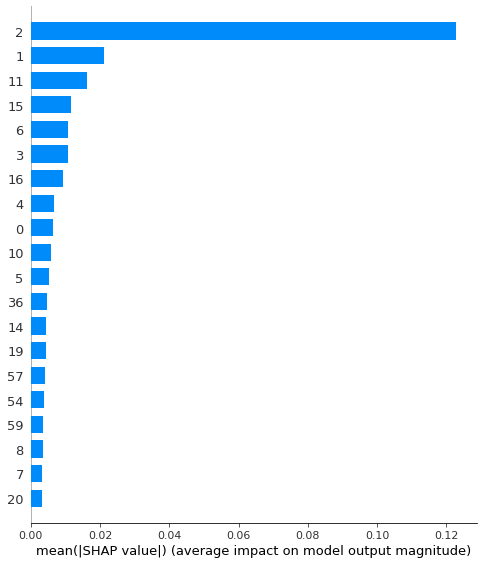

In [48]:
# 特徵重要程度
explainer_pca = shap.TreeExplainer(xgbc_3,x_train_pca, model_output='probability')
shap_values_pca = explainer_pca.shap_values(x_train_pca)
shap.summary_plot(shap_values_pca,x_train_pca,plot_type="bar")

In [49]:
shap_value_pca_1 = pd.DataFrame(shap_values_pca)
shap_value_1_0 = abs(shap_value_pca_1)
shap_value_col_1 = np.sum(shap_value_1_0 , axis = 0)/len(shap_values_pca)
shap_value_col_1 = shap_value_col_1.sort_values()
p = shap_value_col_1/sum(shap_value_col_1)*100
p.sort_values(ascending=False)

2     34.341784
1      5.948335
11     4.509345
15     3.238523
6      3.009920
        ...    
62     0.333105
45     0.315514
26     0.310213
32     0.306655
34     0.280365
Length: 66, dtype: float64

# Case 4 : 做完資料處理 + PCA (n_components = 'mle') + Imbalanced data處理

In [50]:
# summarize class distribution
counter = Counter(y_train_ohe)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1.0, random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X, OU_y = pipeline.fit_resample(x_train_pca, y_train_ohe)
# summarize the new class distribution
counter = Counter(OU_y)
print(counter)

Counter({0: 5479, 1: 997})
Counter({1: 5581, 0: 5479})


In [51]:
xgbc_4 =XGBClassifier()
xgbc_4.fit(OU_X , OU_y)
xgbc_4.score(OU_X , OU_y)

[05:46:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.9999095840867993

In [52]:
xgbc_4.score(x_teset_pca , y_test_ohe)

0.8733786287831995

In [53]:
y_pred_4 = xgbc_4.predict(x_teset_pca)
recall_test_4 = recall_score(np.array(y_test_ohe), y_pred_4, average=None)
precision_test_4 = precision_score(np.array(y_test_ohe), y_pred_4, average=None)
f1_score_test_4 = f1_score(np.array(y_test_ohe), y_pred_4, average=None)
c4=confusion_matrix(y_test_ohe,y_pred_4)
c4

array([[1231,  108],
       [  97,  183]], dtype=int64)

In [54]:
recall_test_4, precision_test_4, f1_score_test_4

(array([0.91934279, 0.65357143]),
 array([0.92695783, 0.62886598]),
 array([0.92313461, 0.64098074]))

In [55]:
accuracy_4 = accuracy_score(y_test_ohe,y_pred_4)
accuracy_4

0.8733786287831995

In [56]:
TP, FP, FN, TN = get_data(c4)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5641499745892586, 0.5643043203039761)

 99%|===================| 10987/11060 [00:36<00:00]        

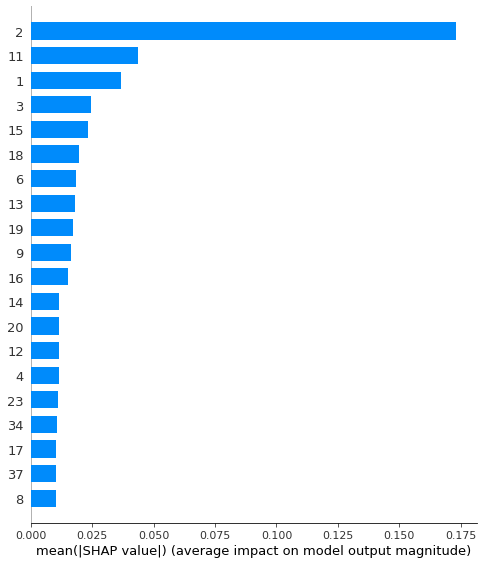

In [57]:
explainer_ada = shap.TreeExplainer(xgbc_4,OU_X, model_output='probability')
shap_values_ada = explainer_ada.shap_values(OU_X)
shap.summary_plot(shap_values_ada,OU_X,plot_type="bar")

In [58]:
shap_value_1_ada = pd.DataFrame(shap_values_ada)
shap_value_1_0_ada = abs(shap_value_1_ada)
shap_value_col_1_ada = np.sum(shap_value_1_0_ada , axis = 0)/len(shap_values_ada)
shap_value_col_1_ada = shap_value_col_1_ada.sort_values()
p = shap_value_col_1_ada/sum(shap_value_col_1_ada)*100
p.sort_values(ascending=False)

2     23.448936
11     5.942229
1      4.962965
3      3.307677
15     3.137786
        ...    
38     0.373129
52     0.371985
65     0.370586
43     0.356740
46     0.269031
Length: 66, dtype: float64

# 將類別型特徵的項目做整合

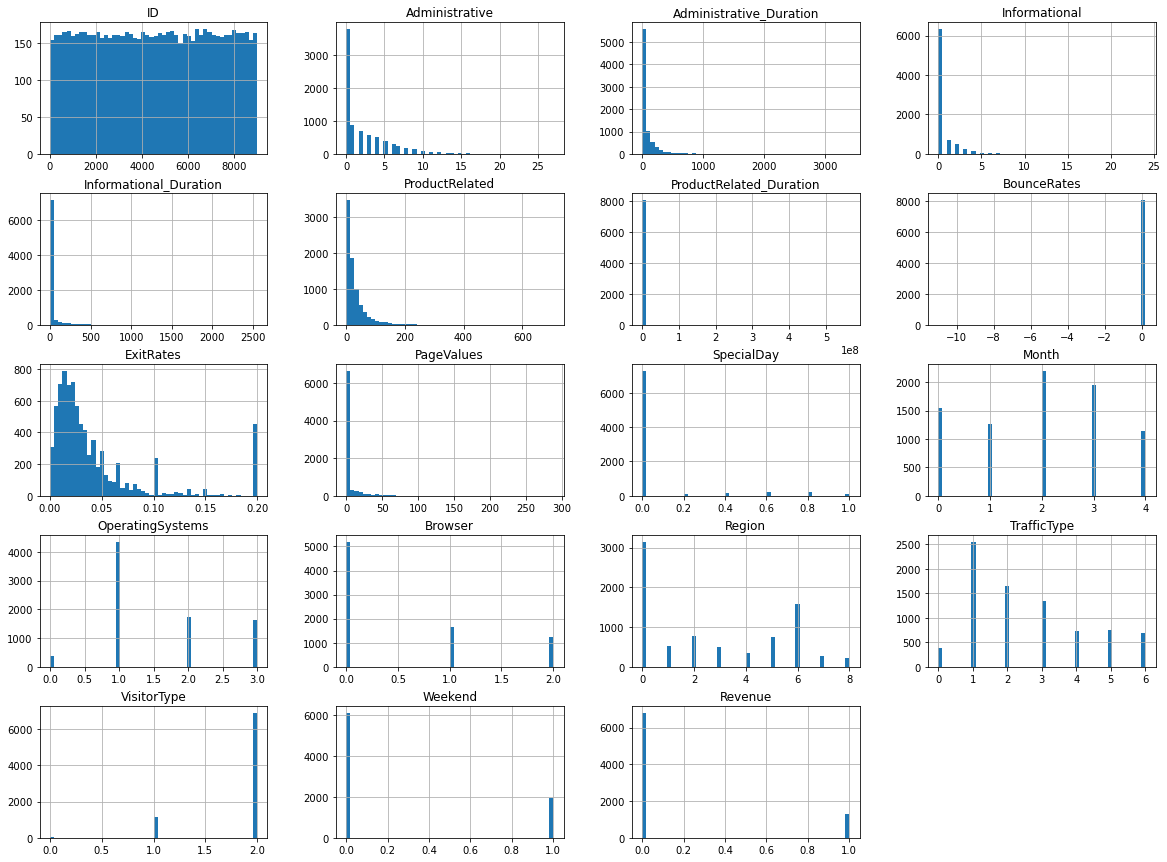

In [59]:
data4 = data3.copy()
data4['Month'] = data3['Month'].apply(new_month)
data4['OperatingSystems'] = data3['OperatingSystems'].apply(new_OperatingSystems)
data4['Browser'] = data3['Browser'].apply(new_browser)
data4['TrafficType'] = data3['TrafficType'].apply(new_TrafficType)

#將每一數值屬性畫出直方圖
%matplotlib inline
data4.hist(bins=50, figsize=(20,15))
plt.show()

In [60]:
#尋找相關性
#使用corr()計算每一對屬性之間的標準相關性係數
corr_matrix = data4.corr()

#查看每一個屬性與是否訂房之間的相關性有多大
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.499459
ProductRelated             0.149078
Administrative             0.142878
Administrative_Duration    0.096156
Informational              0.091202
Informational_Duration     0.068601
Month                      0.051810
Weekend                    0.023159
Browser                    0.017122
ID                        -0.001806
ProductRelated_Duration   -0.005533
Region                    -0.010480
BounceRates               -0.050035
TrafficType               -0.052108
OperatingSystems          -0.073666
SpecialDay                -0.076383
VisitorType               -0.111432
ExitRates                 -0.207819
Name: Revenue, dtype: float64

In [61]:
# 對類別型特徵做One-hot-encoding
df_str_2 = data4.astype({'Month':'category','OperatingSystems':'category','Browser':'category','Region':'category','TrafficType':'category','VisitorType':'category','Weekend':'category'})
df_str_2
df_dum_2 = pd.get_dummies(df_str_2[['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']])

df_str_2.drop(['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend'], axis=1, inplace=True)

df_new_2 = pd.concat([df_dum_2,df_str_2],axis=1)
df_new_2

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
0,0,0,1,0,0,0,0,1,0,0,...,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.4,0
1,0,0,0,0,1,0,1,0,0,1,...,0.000000,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,0
2,0,0,0,1,0,0,1,0,0,1,...,301.000000,0,0.0,38,2621.621429,0.021212,0.044508,10.721172,0.0,0
3,0,0,1,0,0,0,0,0,1,1,...,13.333333,0,0.0,105,2062.443592,0.012205,0.020276,0.000000,0.6,0
4,0,0,1,0,0,0,1,0,0,0,...,0.000000,0,0.0,19,220.384849,0.010526,0.024642,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,0,0,1,0,0,0,1,0,0,0,...,0.000000,0,0.0,4,81.000000,0.000000,0.050000,0.000000,0.4,0
8096,1,0,0,0,0,0,0,1,0,0,...,15.200000,2,62.6,84,4941.698611,0.017647,0.038706,0.000000,0.0,0
8097,1,0,0,0,0,0,1,0,0,1,...,0.000000,0,0.0,25,701.883333,0.000000,0.023333,0.000000,0.0,0
8098,0,0,0,1,0,0,0,0,1,1,...,183.785714,1,90.0,95,3346.501984,0.002118,0.018656,5.932009,0.0,1


In [62]:
#尋找相關性
#使用corr()計算每一對屬性之間的標準相關性係數
corr_matrix = df_new_2.corr()

#查看每一個屬性與是否訂房之間的相關性有多大
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.499459
Month_3                    0.158018
ProductRelated             0.149078
Administrative             0.142878
TrafficType_1              0.118563
VisitorType_1.0            0.116709
Administrative_Duration    0.096156
Informational              0.091202
Informational_Duration     0.068601
TrafficType_6              0.066664
OperatingSystems_1         0.052443
TrafficType_0              0.035160
OperatingSystems_0         0.028453
Weekend_1                  0.023159
Browser_2                  0.019684
Region_0.0                 0.019631
Region_4.0                 0.016641
Region_5.0                 0.011108
VisitorType_0.0            0.010331
Region_3.0                 0.004525
Region_8.0                 0.001859
Month_0                   -0.000537
ID                        -0.001806
Browser_1                 -0.003577
ProductRelated_Duration   -0.005533
TrafficType_4             -0.006006
Region_6.0                -0

# Case 9: 合併特徵類別  no PCA

In [63]:
y_ohe_9 = df_new_2['Revenue'].values
X_ohe_9 = df_new_2.drop(['ID','Revenue'],axis=1)

In [64]:
x_train_ohe_9, x_test_ohe_9, y_train_ohe_9, y_test_ohe_9 = train_test_split(X_ohe_9, y_ohe_9, test_size=0.2, random_state=1)

In [65]:
#特徵標準化
rob_scaler_9 = RobustScaler()
rob_data_9 = x_train_ohe_9.copy()


rob_data_9['rob_scaled_Administrative'] = rob_scaler_9.fit_transform(rob_data_9['Administrative'].values.reshape(-1,1))
rob_data_9['rob_scaled_Administrative_Duration'] = rob_scaler_9.fit_transform(rob_data_9['Administrative_Duration'].values.reshape(-1,1))
rob_data_9['rob_scaled_Informational'] = rob_scaler_9.fit_transform(rob_data_9['Informational'].values.reshape(-1,1))
rob_data_9['rob_scaled_Informational_Duration'] = rob_scaler_9.fit_transform(rob_data_9['Informational_Duration'].values.reshape(-1,1))
rob_data_9['rob_scaled_ProductRelated'] = rob_scaler_9.fit_transform(rob_data_9['ProductRelated'].values.reshape(-1,1))
rob_data_9['rob_scaled_ProductRelated_Duration'] = rob_scaler_9.fit_transform(rob_data_9['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_9['rob_scaled_BounceRates'] = rob_scaler_9.fit_transform(rob_data_9['BounceRates'].values.reshape(-1,1))
rob_data_9['rob_scaled_ExitRates'] = rob_scaler_9.fit_transform(rob_data_9['ExitRates'].values.reshape(-1,1))
rob_data_9['rob_scaled_PageValues'] = rob_scaler_9.fit_transform(rob_data_9['PageValues'].values.reshape(-1,1))
rob_data_9['rob_scaled_SpecialDay'] = rob_scaler_9.fit_transform(rob_data_9['SpecialDay'].values.reshape(-1,1))




rob_data_9.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_9.describe()


,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.186998,0.157505,0.274707,0.237492,0.143298,0.046016,0.536288,0.214330,0.203366,0.646232,...,0.323695,0.797128,0.491198,31.904603,0.449087,79.421443,9.734188e-01,0.495705,5.654681,0.061674
std,0.389940,0.364304,0.446401,0.425579,0.350404,0.209536,0.498720,0.410388,0.402534,0.478175,...,0.820068,1.941321,1.248103,134.282300,1.437651,5480.885946,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-0.468797,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-0.326744,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.750000,0.923654,0.000000,0.000000,0.645161,0.673256,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.500000,36.992502,24.000000,2549.375000,22.161290,434293.175348,1.143863e+01,4.896553,287.953793,1.000000


In [66]:
rob_scaler_9 = RobustScaler()
rob_data_test_9 = x_test_ohe_9.copy()


rob_data_test_9['rob_scaled_Administrative'] = rob_scaler_9.fit_transform(rob_data_test_9['Administrative'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_Administrative_Duration'] = rob_scaler_9.fit_transform(rob_data_test_9['Administrative_Duration'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_Informational'] = rob_scaler_9.fit_transform(rob_data_test_9['Informational'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_Informational_Duration'] = rob_scaler_9.fit_transform(rob_data_test_9['Informational_Duration'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_ProductRelated'] = rob_scaler_9.fit_transform(rob_data_test_9['ProductRelated'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_ProductRelated_Duration'] = rob_scaler_9.fit_transform(rob_data_test_9['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_BounceRates'] = rob_scaler_9.fit_transform(rob_data_test_9['BounceRates'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_ExitRates'] = rob_scaler_9.fit_transform(rob_data_test_9['ExitRates'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_PageValues'] = rob_scaler_9.fit_transform(rob_data_test_9['PageValues'].values.reshape(-1,1))
rob_data_test_9['rob_scaled_SpecialDay'] = rob_scaler_9.fit_transform(rob_data_test_9['SpecialDay'].values.reshape(-1,1))




rob_data_test_9.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test_9.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.201977,0.151328,0.261272,0.254478,0.130945,0.041384,0.544163,0.213712,0.200741,0.628783,...,0.341723,0.819203,0.526868,36.904649,0.477002,0.484469,1.124925,0.499822,6.121047,0.055466
std,0.401599,0.358479,0.439464,0.435702,0.337444,0.199237,0.498200,0.410053,0.400679,0.483280,...,0.858906,2.025238,1.298849,139.024740,1.552211,1.554453,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.465863,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.316023,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.750000,0.913391,0.000000,0.000000,0.666667,0.683977,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.750000,25.976492,14.000000,1511.700000,22.300000,18.769177,11.845923,5.112624,261.491286,1.000000


In [67]:
xgbc_9 =XGBClassifier()
xgbc_9.fit(rob_data_9 , y_train_ohe_9)
xgbc_9.score(rob_data_9 , y_train_ohe_9)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:47:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9941321803582458

In [68]:
xgbc_9.score(rob_data_test_9 , y_test_ohe_9)

0.897467572575664

In [69]:
y_pred_9 = xgbc_9.predict(rob_data_test_9)
recall_test_9 = recall_score(np.array(y_test_ohe_9), y_pred_9, average=None)
precision_test_9 = precision_score(np.array(y_test_ohe_9), y_pred_9, average=None)
f1_score_test_9 = f1_score(np.array(y_test_ohe_9), y_pred_9, average=None)
c9 = confusion_matrix(y_test_ohe_9,y_pred_9)
c9

array([[1280,   59],
       [ 107,  173]], dtype=int64)

In [70]:
recall_test_9, precision_test_9, f1_score_test_9

(array([0.95593727, 0.61785714]),
 array([0.92285508, 0.74568966]),
 array([0.93910492, 0.67578125]))

In [71]:
accuracy_9 = accuracy_score(y_test_ohe_9,y_pred_9)
accuracy_9

0.897467572575664

In [72]:
TP, FP, FN, TN = get_data(c9)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.6155208524079839, 0.6193603419630186)

# Case 11: 合併特徵類別 no PCA + Imbalance data處理

In [126]:
# summarize class distribution
counter = Counter(y_train_ohe_9)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1,random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X_11, OU_y_11 = pipeline.fit_resample(rob_data_9, y_train_ohe_9)
# summarize the new class distribution
counter = Counter(OU_y_11)
print(counter)

Counter({0: 5479, 1: 997})
Counter({0: 5479, 1: 5430})


In [127]:
xgbc_11 =XGBClassifier()
xgbc_11.fit(OU_X_11 , OU_y_11)
xgbc_11.score(OU_X_11 , OU_y_11)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9976166468053901

In [128]:
xgbc_11.score(rob_data_test_9 , y_test_ohe_9)

0.8820259419394688

In [129]:
y_pred_11 = xgbc_11.predict(rob_data_test_9)
recall_test_11 = recall_score(np.array(y_test_ohe_9), y_pred_11, average=None)
precision_test_11 = precision_score(np.array(y_test_ohe_9), y_pred_11, average=None)
f1_score_test_11 = f1_score(np.array(y_test_ohe_9), y_pred_11, average=None)
c11=confusion_matrix(y_test_ohe_9,y_pred_11)
c11

array([[1252,   87],
       [ 104,  176]], dtype=int64)

In [130]:
recall_test_11, precision_test_11, f1_score_test_11

(array([0.93502614, 0.62857143]),
 array([0.92330383, 0.66920152]),
 array([0.92912801, 0.64825046]))

In [131]:
accuracy_11 = accuracy_score(y_test_ohe_9,y_pred_11)
accuracy_11

0.8820259419394688

In [132]:
TP, FP, FN, TN = get_data(c11)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5774619211655054, 0.5778707270694273)

# Case 5 : 合併特徵類別 + PCA (n_components = 'mle') + Imbalanced data處理

### Split x and y

In [73]:
y_ohe_2 = df_new_2['Revenue'].values
X_ohe_2 = df_new_2.drop(['ID','Revenue'],axis=1)

### 分割訓練集 / 測試集 80/20

In [74]:
x_train_ohe_2, x_test_ohe_2, y_train_ohe_2, y_test_ohe_2 = train_test_split(X_ohe_2, y_ohe_2, test_size=0.2, random_state=1)

In [75]:
#特徵標準化
rob_scaler_2 = RobustScaler()
rob_data_2 = x_train_ohe_2.copy()


rob_data_2['rob_scaled_Administrative'] = rob_scaler_2.fit_transform(rob_data_2['Administrative'].values.reshape(-1,1))
rob_data_2['rob_scaled_Administrative_Duration'] = rob_scaler_2.fit_transform(rob_data_2['Administrative_Duration'].values.reshape(-1,1))
rob_data_2['rob_scaled_Informational'] = rob_scaler_2.fit_transform(rob_data_2['Informational'].values.reshape(-1,1))
rob_data_2['rob_scaled_Informational_Duration'] = rob_scaler_2.fit_transform(rob_data_2['Informational_Duration'].values.reshape(-1,1))
rob_data_2['rob_scaled_ProductRelated'] = rob_scaler_2.fit_transform(rob_data_2['ProductRelated'].values.reshape(-1,1))
rob_data_2['rob_scaled_ProductRelated_Duration'] = rob_scaler_2.fit_transform(rob_data_2['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_2['rob_scaled_BounceRates'] = rob_scaler_2.fit_transform(rob_data_2['BounceRates'].values.reshape(-1,1))
rob_data_2['rob_scaled_ExitRates'] = rob_scaler_2.fit_transform(rob_data_2['ExitRates'].values.reshape(-1,1))
rob_data_2['rob_scaled_PageValues'] = rob_scaler_2.fit_transform(rob_data_2['PageValues'].values.reshape(-1,1))
rob_data_2['rob_scaled_SpecialDay'] = rob_scaler_2.fit_transform(rob_data_2['SpecialDay'].values.reshape(-1,1))




rob_data_2.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_2.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.186998,0.157505,0.274707,0.237492,0.143298,0.046016,0.536288,0.214330,0.203366,0.646232,...,0.323695,0.797128,0.491198,31.904603,0.449087,79.421443,9.734188e-01,0.495705,5.654681,0.061674
std,0.389940,0.364304,0.446401,0.425579,0.350404,0.209536,0.498720,0.410388,0.402534,0.478175,...,0.820068,1.941321,1.248103,134.282300,1.437651,5480.885946,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-0.468797,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-0.326744,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.750000,0.923654,0.000000,0.000000,0.645161,0.673256,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,6.500000,36.992502,24.000000,2549.375000,22.161290,434293.175348,1.143863e+01,4.896553,287.953793,1.000000


In [76]:
rob_scaler_2 = RobustScaler()
rob_data_test_2 = x_test_ohe_2.copy()


rob_data_test_2['rob_scaled_Administrative'] = rob_scaler_2.fit_transform(rob_data_test_2['Administrative'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_Administrative_Duration'] = rob_scaler_2.fit_transform(rob_data_test_2['Administrative_Duration'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_Informational'] = rob_scaler_2.fit_transform(rob_data_test_2['Informational'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_Informational_Duration'] = rob_scaler_2.fit_transform(rob_data_test_2['Informational_Duration'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_ProductRelated'] = rob_scaler_2.fit_transform(rob_data_test_2['ProductRelated'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_ProductRelated_Duration'] = rob_scaler_2.fit_transform(rob_data_test_2['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_BounceRates'] = rob_scaler_2.fit_transform(rob_data_test_2['BounceRates'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_ExitRates'] = rob_scaler_2.fit_transform(rob_data_test_2['ExitRates'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_PageValues'] = rob_scaler_2.fit_transform(rob_data_test_2['PageValues'].values.reshape(-1,1))
rob_data_test_2['rob_scaled_SpecialDay'] = rob_scaler_2.fit_transform(rob_data_test_2['SpecialDay'].values.reshape(-1,1))




rob_data_test_2.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test_2.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.201977,0.151328,0.261272,0.254478,0.130945,0.041384,0.544163,0.213712,0.200741,0.628783,...,0.341723,0.819203,0.526868,36.904649,0.477002,0.484469,1.124925,0.499822,6.121047,0.055466
std,0.401599,0.358479,0.439464,0.435702,0.337444,0.199237,0.498200,0.410053,0.400679,0.483280,...,0.858906,2.025238,1.298849,139.024740,1.552211,1.554453,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.465863,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.316023,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.750000,0.913391,0.000000,0.000000,0.666667,0.683977,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.750000,25.976492,14.000000,1511.700000,22.300000,18.769177,11.845923,5.112624,261.491286,1.000000


In [77]:
##特徵pca
pca_2 = PCA(n_components='mle',random_state=1)
pca_2.fit(rob_data_2)
x_train_pca_2 = pca_2.transform(rob_data_2)
x_teset_pca_2 = pca_2.transform(rob_data_test_2)

x_train_pca_2 = pd.DataFrame(x_train_pca_2)
x_teset_pca_2 = pd.DataFrame(x_teset_pca_2)

In [78]:
x_teset_pca_2

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,-79.781358,-31.957548,-5.532330,-0.839105,-1.095003,0.305034,-0.164587,0.073071,-0.374804,0.476172,...,-0.138461,-0.000955,0.867385,-0.290853,-0.181625,-0.107071,0.010800,-0.043959,-0.030295,0.011222
1,-78.753232,-31.872071,-5.375588,1.583949,12.085089,7.336106,-1.129985,1.232592,0.801437,-0.771698,...,0.728285,0.339338,0.774369,-0.247616,-0.144821,-0.120431,-0.059810,-0.008805,-0.030291,0.022822
2,-78.102049,-31.952290,-5.530359,-0.801232,-0.573387,-0.704938,0.914887,0.520060,-0.063402,0.194679,...,0.377574,-0.312611,-0.485955,-0.063154,-0.176165,-0.054527,-0.007199,-0.033548,-0.017371,0.017373
3,-79.755872,-31.932332,-5.489216,1.560404,-1.193652,0.556476,-0.295231,-0.156683,1.131469,-0.742277,...,0.411228,-0.301033,-0.479758,-0.039564,-0.148151,-0.054645,0.065273,-0.217630,-0.025869,0.028174
4,-79.434766,-31.924295,-5.455691,1.632434,0.240527,-0.378483,-1.112454,0.332263,-0.596306,-0.305902,...,0.132023,0.104600,-0.049004,0.068558,-0.025008,0.000540,-0.013214,-0.032048,-0.026428,0.022858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,-78.527954,194.108631,0.086310,-1.125068,0.556882,-1.208400,0.142966,-1.298104,0.362206,-0.759106,...,-0.108671,-0.004628,-0.060426,-0.403455,-0.000393,0.150219,-0.709748,-0.337232,-0.031815,0.042670
1615,-77.702754,-31.936515,-5.486412,0.847499,-0.677524,-0.270589,-0.571202,0.218649,-0.625891,-0.232929,...,-0.052826,0.053987,-0.044424,0.034048,0.004149,-0.013676,-0.015368,-0.006271,-0.019850,0.017592
1616,-79.637406,-31.929781,-5.473803,1.316572,-0.122234,-0.013447,-0.765282,0.012664,1.216048,-0.619902,...,-0.420889,-0.238956,0.053608,-0.042954,0.051993,-0.050942,-0.062263,0.002027,-0.004235,0.018976
1617,-79.606558,-31.951546,-5.527165,-0.305701,-1.128451,0.470482,0.176313,-0.097691,1.538483,0.519729,...,-0.467091,-0.257644,0.019098,-0.070706,0.027644,-0.067087,-0.018757,0.014461,-0.024216,0.022783


In [79]:
# summarize class distribution
counter = Counter(y_train_ohe_2)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1,random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X_2, OU_y_2 = pipeline.fit_resample(x_train_pca_2, y_train_ohe_2)
# summarize the new class distribution
counter = Counter(OU_y_2)
print(counter)

Counter({0: 5479, 1: 997})
Counter({0: 5479, 1: 5430})


In [80]:
xgbc_5 =XGBClassifier()
xgbc_5.fit(OU_X_2 , OU_y_2)
xgbc_5.score(OU_X_2 , OU_y_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:47:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9995416628471904

In [81]:
xgbc_5.score(x_teset_pca_2 , y_test_ohe_2)

0.871525633106856

In [82]:
y_pred_5 = xgbc_5.predict(x_teset_pca_2)
recall_test_5 = recall_score(np.array(y_test_ohe_2), y_pred_5, average=None)
precision_test_5 = precision_score(np.array(y_test_ohe_2), y_pred_5, average=None)
f1_score_test_5 = f1_score(np.array(y_test_ohe_2), y_pred_5, average=None)
c5=confusion_matrix(y_test_ohe_2,y_pred_5)
c5

array([[1227,  112],
       [  96,  184]], dtype=int64)

In [83]:
recall_test_5, precision_test_5, f1_score_test_5

(array([0.91635549, 0.65714286]),
 array([0.92743764, 0.62162162]),
 array([0.92186326, 0.63888889]))

In [84]:
accuracy_5 = accuracy_score(y_test_ohe_2,y_pred_5)
accuracy_5

0.871525633106856

In [85]:
TP, FP, FN, TN = get_data(c5)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5608254736666386, 0.5611457738918311)

# Case10: Drop掉與預測目標不太相關的特徵 no PCA
abs(corr)<=0.01

In [86]:
y_ohe_10=df_new_2['Revenue'].values
X_ohe_10=df_new_2.drop(['ID','Revenue','Month_0','Region_8.0','Region_3.0','Browser_1','ProductRelated_Duration','TrafficType_4','Region_6.0'],axis=1)

In [87]:
x_train_ohe_10, x_test_ohe_10, y_train_ohe_10, y_test_ohe_10 = train_test_split(X_ohe_10, y_ohe_10, test_size=0.2, random_state=1)

In [88]:
#特徵標準化
rob_scaler_10 = RobustScaler()
rob_data_10 = x_train_ohe_10.copy()


rob_data_10['rob_scaled_Administrative'] = rob_scaler_10.fit_transform(rob_data_10['Administrative'].values.reshape(-1,1))
rob_data_10['rob_scaled_Administrative_Duration'] = rob_scaler_10.fit_transform(rob_data_10['Administrative_Duration'].values.reshape(-1,1))
rob_data_10['rob_scaled_Informational'] = rob_scaler_10.fit_transform(rob_data_10['Informational'].values.reshape(-1,1))
rob_data_10['rob_scaled_Informational_Duration'] = rob_scaler_10.fit_transform(rob_data_10['Informational_Duration'].values.reshape(-1,1))
rob_data_10['rob_scaled_ProductRelated'] = rob_scaler_10.fit_transform(rob_data_10['ProductRelated'].values.reshape(-1,1))

rob_data_10['rob_scaled_BounceRates'] = rob_scaler_10.fit_transform(rob_data_10['BounceRates'].values.reshape(-1,1))
rob_data_10['rob_scaled_ExitRates'] = rob_scaler_10.fit_transform(rob_data_10['ExitRates'].values.reshape(-1,1))
rob_data_10['rob_scaled_PageValues'] = rob_scaler_10.fit_transform(rob_data_10['PageValues'].values.reshape(-1,1))
rob_data_10['rob_scaled_SpecialDay'] = rob_scaler_10.fit_transform(rob_data_10['SpecialDay'].values.reshape(-1,1))




rob_data_10.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_10.describe()

,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,Browser_2,...,Weekend_1,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.157505,0.274707,0.237492,0.143298,0.046016,0.536288,0.214330,0.203366,0.646232,0.152100,...,0.243360,0.323695,0.797128,0.491198,31.904603,0.449087,9.734188e-01,0.495705,5.654681,0.061674
std,0.364304,0.446401,0.425579,0.350404,0.209536,0.498720,0.410388,0.402534,0.478175,0.359146,...,0.429144,0.820068,1.941321,1.248103,134.282300,1.437651,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.750000,0.923654,0.000000,0.000000,0.645161,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.500000,36.992502,24.000000,2549.375000,22.161290,1.143863e+01,4.896553,287.953793,1.000000


In [89]:
rob_scaler_10 = RobustScaler()
rob_data_test_10 = x_test_ohe_10.copy()


rob_data_test_10['rob_scaled_Administrative'] = rob_scaler_10.fit_transform(rob_data_test_10['Administrative'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_Administrative_Duration'] = rob_scaler_10.fit_transform(rob_data_test_10['Administrative_Duration'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_Informational'] = rob_scaler_10.fit_transform(rob_data_test_10['Informational'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_Informational_Duration'] = rob_scaler_10.fit_transform(rob_data_test_10['Informational_Duration'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_ProductRelated'] = rob_scaler_10.fit_transform(rob_data_test_10['ProductRelated'].values.reshape(-1,1))

rob_data_test_10['rob_scaled_BounceRates'] = rob_scaler_10.fit_transform(rob_data_test_10['BounceRates'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_ExitRates'] = rob_scaler_10.fit_transform(rob_data_test_10['ExitRates'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_PageValues'] = rob_scaler_10.fit_transform(rob_data_test_10['PageValues'].values.reshape(-1,1))
rob_data_test_10['rob_scaled_SpecialDay'] = rob_scaler_10.fit_transform(rob_data_test_10['SpecialDay'].values.reshape(-1,1))




rob_data_test_10.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test_10.describe()

,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,Browser_2,...,Weekend_1,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.151328,0.261272,0.254478,0.130945,0.041384,0.544163,0.213712,0.200741,0.628783,0.166770,...,0.231624,0.341723,0.819203,0.526868,36.904649,0.477002,1.124925,0.499822,6.121047,0.055466
std,0.358479,0.439464,0.435702,0.337444,0.199237,0.498200,0.410053,0.400679,0.483280,0.372885,...,0.422001,0.858906,2.025238,1.298849,139.024740,1.552211,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.750000,0.913391,0.000000,0.000000,0.666667,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.750000,25.976492,14.000000,1511.700000,22.300000,11.845923,5.112624,261.491286,1.000000


In [90]:
xgbc_10 =XGBClassifier()
xgbc_10.fit(rob_data_10 , y_train_ohe_10)
xgbc_10.score(rob_data_10 , y_train_ohe_10)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[05:47:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9918159357628166

In [91]:
xgbc_10.score(rob_data_test_10 , y_test_ohe_10)

0.887584928968499

In [92]:
y_pred_10 = xgbc_10.predict(rob_data_test_10)
recall_test_10 = recall_score(np.array(y_test_ohe_10), y_pred_10, average=None)
precision_test_10 = precision_score(np.array(y_test_ohe_10), y_pred_10, average=None)
f1_score_test_10 = f1_score(np.array(y_test_ohe_10), y_pred_10, average=None)
c10 = confusion_matrix(y_test_ohe_10,y_pred_10)
c10

array([[1278,   61],
       [ 121,  159]], dtype=int64)

In [93]:
recall_test_10, precision_test_10, f1_score_test_10

(array([0.95444361, 0.56785714]),
 array([0.91350965, 0.72272727]),
 array([0.93352812, 0.636     ]))

In [94]:
accuracy_10 = accuracy_score(y_test_ohe_10,y_pred_10)
accuracy_10

0.887584928968499

In [95]:
TP, FP, FN, TN = get_data(c10)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5706571470202534, 0.5764607762511087)

# Case6: Drop掉與預測目標不太相關的特徵
abs(corr)<=0.01

### Split x and y

In [96]:
y_ohe_drop=df_new_2['Revenue'].values
X_ohe_drop=df_new_2.drop(['ID','Revenue','Month_0','Region_8.0','Region_3.0','Browser_1','ProductRelated_Duration','TrafficType_4','Region_6.0'],axis=1)

### 分割訓練集 / 測試集 80/20

In [97]:
x_train_ohe_drop, x_test_ohe_drop, y_train_ohe_drop, y_test_ohe_drop = train_test_split(X_ohe_drop, y_ohe_drop, test_size=0.2, random_state=1)

In [98]:
#特徵標準化
rob_scaler_3 = RobustScaler()
rob_data_3 = x_train_ohe_drop.copy()


rob_data_3['rob_scaled_Administrative'] = rob_scaler_3.fit_transform(rob_data_3['Administrative'].values.reshape(-1,1))
rob_data_3['rob_scaled_Administrative_Duration'] = rob_scaler_3.fit_transform(rob_data_3['Administrative_Duration'].values.reshape(-1,1))
rob_data_3['rob_scaled_Informational'] = rob_scaler_3.fit_transform(rob_data_3['Informational'].values.reshape(-1,1))
rob_data_3['rob_scaled_Informational_Duration'] = rob_scaler_3.fit_transform(rob_data_3['Informational_Duration'].values.reshape(-1,1))
rob_data_3['rob_scaled_ProductRelated'] = rob_scaler_3.fit_transform(rob_data_3['ProductRelated'].values.reshape(-1,1))

rob_data_3['rob_scaled_BounceRates'] = rob_scaler_3.fit_transform(rob_data_3['BounceRates'].values.reshape(-1,1))
rob_data_3['rob_scaled_ExitRates'] = rob_scaler_3.fit_transform(rob_data_3['ExitRates'].values.reshape(-1,1))
rob_data_3['rob_scaled_PageValues'] = rob_scaler_3.fit_transform(rob_data_3['PageValues'].values.reshape(-1,1))
rob_data_3['rob_scaled_SpecialDay'] = rob_scaler_3.fit_transform(rob_data_3['SpecialDay'].values.reshape(-1,1))




rob_data_3.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_3.describe()

,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,Browser_2,...,Weekend_1,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.157505,0.274707,0.237492,0.143298,0.046016,0.536288,0.214330,0.203366,0.646232,0.152100,...,0.243360,0.323695,0.797128,0.491198,31.904603,0.449087,9.734188e-01,0.495705,5.654681,0.061674
std,0.364304,0.446401,0.425579,0.350404,0.209536,0.498720,0.410388,0.402534,0.478175,0.359146,...,0.429144,0.820068,1.941321,1.248103,134.282300,1.437651,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.750000,0.923654,0.000000,0.000000,0.645161,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.500000,36.992502,24.000000,2549.375000,22.161290,1.143863e+01,4.896553,287.953793,1.000000


In [99]:
rob_scaler_3 = RobustScaler()
rob_data_test_3 = x_test_ohe_drop.copy()


rob_data_test_3['rob_scaled_Administrative'] = rob_scaler_3.fit_transform(rob_data_test_3['Administrative'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_Administrative_Duration'] = rob_scaler_3.fit_transform(rob_data_test_3['Administrative_Duration'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_Informational'] = rob_scaler_3.fit_transform(rob_data_test_3['Informational'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_Informational_Duration'] = rob_scaler_3.fit_transform(rob_data_test_3['Informational_Duration'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_ProductRelated'] = rob_scaler_3.fit_transform(rob_data_test_3['ProductRelated'].values.reshape(-1,1))

rob_data_test_3['rob_scaled_BounceRates'] = rob_scaler_3.fit_transform(rob_data_test_3['BounceRates'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_ExitRates'] = rob_scaler_3.fit_transform(rob_data_test_3['ExitRates'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_PageValues'] = rob_scaler_3.fit_transform(rob_data_test_3['PageValues'].values.reshape(-1,1))
rob_data_test_3['rob_scaled_SpecialDay'] = rob_scaler_3.fit_transform(rob_data_test_3['SpecialDay'].values.reshape(-1,1))




rob_data_test_3.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test_3.describe()

,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,Browser_2,...,Weekend_1,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.151328,0.261272,0.254478,0.130945,0.041384,0.544163,0.213712,0.200741,0.628783,0.166770,...,0.231624,0.341723,0.819203,0.526868,36.904649,0.477002,1.124925,0.499822,6.121047,0.055466
std,0.358479,0.439464,0.435702,0.337444,0.199237,0.498200,0.410053,0.400679,0.483280,0.372885,...,0.422001,0.858906,2.025238,1.298849,139.024740,1.552211,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.750000,0.913391,0.000000,0.000000,0.666667,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.750000,25.976492,14.000000,1511.700000,22.300000,11.845923,5.112624,261.491286,1.000000


In [100]:
##特徵pca
pca_3 = PCA(n_components='mle',random_state=1)
pca_3.fit(rob_data_3)
x_train_pca_3 = pca_3.transform(rob_data_3)
x_teset_pca_3 = pca_3.transform(rob_data_test_3)

x_train_pca_3 = pd.DataFrame(x_train_pca_3)
x_teset_pca_3 = pd.DataFrame(x_teset_pca_3)

In [101]:
x_teset_pca_3

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-31.952648,-5.531419,-0.839619,-1.093674,0.315992,-0.169627,0.045409,-0.122938,0.552141,0.100332,...,-0.116804,-0.087052,-0.184749,-0.057620,0.084721,-0.027900,-0.218961,-0.012964,0.000707,0.013458
1,-31.867125,-5.374381,1.584225,12.092622,7.312629,-1.124364,1.282231,0.266913,-0.903372,1.959901,...,-0.035773,-0.067130,-0.271296,-0.103851,0.053153,0.039700,-0.207976,-0.070038,-0.050439,0.028116
2,-31.947477,-5.529077,-0.801711,-0.581092,-0.699905,0.913964,0.502425,0.028045,0.241316,0.230615,...,-0.421281,0.432088,0.265785,0.266352,-0.206891,0.046023,0.111919,0.021298,-0.047774,0.014021
3,-31.927340,-5.487923,1.560696,-1.187603,0.528167,-0.279600,-0.080566,0.564163,-0.903472,0.083312,...,-0.365763,0.402941,0.209106,-0.115393,-0.062248,-0.235513,0.116710,-0.045704,-0.090777,0.025866
4,-31.919402,-5.454414,1.631957,0.232855,-0.373589,-1.116208,0.293456,-0.654457,-0.049211,0.017021,...,-0.003481,0.036184,0.042427,0.374844,-0.184541,0.073921,0.031190,0.013055,-0.073478,0.021984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,194.113557,0.087283,-1.124627,0.562648,-1.235590,0.158810,-1.244798,-0.172846,-0.642472,-0.852997,...,-0.067052,0.098971,-0.044578,-0.106890,0.093316,0.006600,0.010908,-0.614333,-0.064874,0.073737
1615,-31.931759,-5.485449,0.846985,-0.676558,-0.261830,-0.580145,0.188279,-0.650851,-0.018398,0.058799,...,0.094988,-0.008415,0.034903,-0.082798,0.007746,-0.019564,0.025128,-0.007971,0.007946,0.016989
1616,-31.924751,-5.471818,1.316548,-0.125965,-0.045105,-0.729035,0.095352,0.666373,-0.765775,-0.376640,...,-0.010066,-0.163699,0.044826,0.404926,-0.102791,0.086687,-0.206635,-0.114591,0.284224,0.038809
1617,-31.946527,-5.525718,-0.305700,-1.129842,0.439743,0.210760,-0.015422,1.413695,0.140520,0.325985,...,-0.050821,0.072521,0.172368,0.388054,-0.193301,0.070891,0.059931,-0.093639,0.293010,0.035600


In [102]:
# summarize class distribution
counter = Counter(y_train_ohe_2)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1,random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X_3, OU_y_3 = pipeline.fit_resample(x_train_pca_3, y_train_ohe_drop)
# summarize the new class distribution
counter = Counter(OU_y_3)
print(counter)

Counter({0: 5479, 1: 997})
Counter({0: 5479, 1: 5412})


In [103]:
xgbc_6 =XGBClassifier()
xgbc_6.fit(OU_X_3 , OU_y_3)
xgbc_6.score(OU_X_3 , OU_y_3)

[05:47:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


1.0

In [104]:
xgbc_6.score(x_teset_pca_3 , y_test_ohe_drop)

0.8746139592340951

In [105]:
y_pred_6 = xgbc_6.predict(x_teset_pca_3)
recall_test_6 = recall_score(np.array(y_test_ohe_drop), y_pred_6, average=None)
precision_test_6 = precision_score(np.array(y_test_ohe_drop), y_pred_6, average=None)
f1_score_test_6 = f1_score(np.array(y_test_ohe_drop), y_pred_6, average=None)
c6 = confusion_matrix(y_test_ohe_drop,y_pred_6)
c6

array([[1230,  109],
       [  94,  186]], dtype=int64)

In [106]:
recall_test_6, precision_test_6, f1_score_test_6

(array([0.91859597, 0.66428571]),
 array([0.92900302, 0.63050847]),
 array([0.92377018, 0.64695652]))

In [107]:
accuracy_6 = accuracy_score(y_test_ohe_drop,y_pred_6)
accuracy_6

0.8746139592340951

In [108]:
TP, FP, FN, TN = get_data(c6)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5707897743968134, 0.5710770538242703)

# Case 7:Drop掉與預測目標不太相關的特徵-2
abs(corr)<=0.05

### Split x and y

In [109]:
y_ohe_drop_2=df_new_2['Revenue'].values
X_ohe_drop_2=df_new_2.drop(['ID','Revenue','Month_0','Region_8.0','Region_3.0','Browser_1','ProductRelated_Duration','TrafficType_4','Region_6.0',
                          'VisitorType_0.0','Region_5.0','Region_4.0','Region_0.0','Browser_2','Weekend_1','OperatingSystems_0','TrafficType_0',
                          'Browser_0','OperatingSystems_2','Region_1.0','Region_2.0','Region_7.0','Weekend_0','Month_4'],axis=1)

### 分割訓練集 / 測試集 80/20

In [110]:
x_train_ohe_drop_2, x_test_ohe_drop_2, y_train_ohe_drop_2, y_test_ohe_drop_2 = train_test_split(X_ohe_drop_2, y_ohe_drop_2, test_size=0.2, random_state=1)

In [111]:
#特徵標準化
rob_scaler_4 = RobustScaler()
rob_data_4 = x_train_ohe_drop_2.copy()


rob_data_4['rob_scaled_Administrative'] = rob_scaler_4.fit_transform(rob_data_4['Administrative'].values.reshape(-1,1))
rob_data_4['rob_scaled_Administrative_Duration'] = rob_scaler_4.fit_transform(rob_data_4['Administrative_Duration'].values.reshape(-1,1))
rob_data_4['rob_scaled_Informational'] = rob_scaler_4.fit_transform(rob_data_4['Informational'].values.reshape(-1,1))
rob_data_4['rob_scaled_Informational_Duration'] = rob_scaler_4.fit_transform(rob_data_4['Informational_Duration'].values.reshape(-1,1))
rob_data_4['rob_scaled_ProductRelated'] = rob_scaler_4.fit_transform(rob_data_4['ProductRelated'].values.reshape(-1,1))

rob_data_4['rob_scaled_BounceRates'] = rob_scaler_4.fit_transform(rob_data_4['BounceRates'].values.reshape(-1,1))
rob_data_4['rob_scaled_ExitRates'] = rob_scaler_4.fit_transform(rob_data_4['ExitRates'].values.reshape(-1,1))
rob_data_4['rob_scaled_PageValues'] = rob_scaler_4.fit_transform(rob_data_4['PageValues'].values.reshape(-1,1))
rob_data_4['rob_scaled_SpecialDay'] = rob_scaler_4.fit_transform(rob_data_4['SpecialDay'].values.reshape(-1,1))




rob_data_4.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_4.describe()

,Month_1,Month_2,Month_3,OperatingSystems_1,OperatingSystems_3,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_5,TrafficType_6,...,VisitorType_2.0,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,...,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6476.000000,6.476000e+03,6476.000000,6476.000000,6476.000000
mean,0.157505,0.274707,0.237492,0.536288,0.203366,0.314855,0.205683,0.167542,0.092187,0.084002,...,0.860716,0.323695,0.797128,0.491198,31.904603,0.449087,9.734188e-01,0.495705,5.654681,0.061674
std,0.364304,0.446401,0.425579,0.498720,0.402534,0.464494,0.404231,0.373488,0.289311,0.277413,...,0.346269,0.820068,1.941321,1.248103,134.282300,1.437651,8.471912e+00,1.347286,17.755066,0.199663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.076346,0.000000,0.000000,-0.580645,-6.400272e+02,-0.703492,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,-0.250000,-0.076346,0.000000,0.000000,-0.354839,-1.946836e-01,-0.303480,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.257675e-17,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.750000,0.923654,0.000000,0.000000,0.645161,8.053164e-01,0.696520,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.500000,36.992502,24.000000,2549.375000,22.161290,1.143863e+01,4.896553,287.953793,1.000000


In [112]:
rob_scaler_4 = RobustScaler()
rob_data_test_4 = x_test_ohe_drop_2.copy()


rob_data_test_4['rob_scaled_Administrative'] = rob_scaler_4.fit_transform(rob_data_test_4['Administrative'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_Administrative_Duration'] = rob_scaler_4.fit_transform(rob_data_test_4['Administrative_Duration'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_Informational'] = rob_scaler_4.fit_transform(rob_data_test_4['Informational'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_Informational_Duration'] = rob_scaler_4.fit_transform(rob_data_test_4['Informational_Duration'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_ProductRelated'] = rob_scaler_4.fit_transform(rob_data_test_4['ProductRelated'].values.reshape(-1,1))

rob_data_test_4['rob_scaled_BounceRates'] = rob_scaler_4.fit_transform(rob_data_test_4['BounceRates'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_ExitRates'] = rob_scaler_4.fit_transform(rob_data_test_4['ExitRates'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_PageValues'] = rob_scaler_4.fit_transform(rob_data_test_4['PageValues'].values.reshape(-1,1))
rob_data_test_4['rob_scaled_SpecialDay'] = rob_scaler_4.fit_transform(rob_data_test_4['SpecialDay'].values.reshape(-1,1))




rob_data_test_4.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test_4.describe()

,Month_1,Month_2,Month_3,OperatingSystems_1,OperatingSystems_3,TrafficType_1,TrafficType_2,TrafficType_3,TrafficType_5,TrafficType_6,...,VisitorType_2.0,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,...,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000,1619.000000
mean,0.151328,0.261272,0.254478,0.544163,0.200741,0.319951,0.197653,0.157505,0.095120,0.087708,...,0.827671,0.341723,0.819203,0.526868,36.904649,0.477002,1.124925,0.499822,6.121047,0.055466
std,0.358479,0.439464,0.435702,0.498200,0.400679,0.466601,0.398352,0.364388,0.293472,0.282958,...,0.377782,0.858906,2.025238,1.298849,139.024740,1.552211,2.835459,1.377661,18.689034,0.190015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.250000,-0.086609,0.000000,0.000000,-0.566667,-0.153837,-0.730375,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,-0.250000,-0.086609,0.000000,0.000000,-0.333333,-0.153837,-0.313009,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.750000,0.913391,0.000000,0.000000,0.666667,0.846163,0.686991,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.750000,25.976492,14.000000,1511.700000,22.300000,11.845923,5.112624,261.491286,1.000000


In [113]:
##特徵pca
pca_4 = PCA(n_components='mle',random_state=1)
pca_4.fit(rob_data_4)
x_train_pca_4 = pca_4.transform(rob_data_4)
x_teset_pca_4 = pca_4.transform(rob_data_test_4)

x_train_pca_4 = pd.DataFrame(x_train_pca_4)
x_teset_pca_4 = pd.DataFrame(x_teset_pca_4)

In [114]:
x_teset_pca_4

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-31.952697,-5.531152,-0.839517,-1.094184,0.331764,-0.191138,0.014944,-0.117137,1.073829,-0.034399,-0.168373,-0.502126,0.465151,-0.429183,0.732219,-0.398700,0.280592,0.286986,-0.016917,-0.061775
1,-31.866885,-5.373834,1.585956,12.107654,7.258218,-1.131360,1.299106,1.935907,0.767495,-0.117988,-0.512014,0.303544,0.067190,0.479526,0.477733,0.983261,-0.451486,0.158733,0.060800,-0.127340
2,-31.947493,-5.528549,-0.801398,-0.579716,-0.687032,0.896977,0.487988,0.037299,1.002908,-0.434233,0.149955,0.162001,0.143316,0.666974,-0.076943,-0.365069,0.101864,-0.502892,-0.014545,-0.034245
3,-31.927067,-5.487116,1.562641,-1.175038,0.475974,-0.261232,-0.035762,0.131449,0.177635,-0.789705,0.561855,-0.109251,0.292788,0.487843,-0.507793,0.175319,0.059461,0.177510,-0.221544,-0.150637
4,-31.919518,-5.454273,1.631507,0.233821,-0.356186,-1.155529,0.263585,0.190352,-0.373476,0.424358,0.075449,-0.424127,-0.402708,0.126999,0.048527,0.004147,0.169280,-0.367019,0.019747,-0.033570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,194.113609,0.086589,-1.125780,0.573075,-1.260381,0.165643,-1.240876,-0.657280,-0.709960,0.390634,0.046075,-0.312097,-0.423371,0.144602,0.033618,-0.005357,0.184704,-0.330646,0.029656,-0.025186
1615,-31.931875,-5.485308,0.846534,-0.675678,-0.242526,-0.618668,0.160629,0.227886,-0.397274,0.554761,-0.191433,-0.118236,-0.771804,0.538720,0.327682,-0.023542,-0.214496,0.178539,-0.010249,0.016164
1616,-31.924512,-5.471272,1.318278,-0.115548,-0.097936,-0.710252,0.137205,-0.372244,0.220426,-0.268508,-0.165833,-0.084698,-0.017336,0.086712,-0.057635,0.465210,0.432559,-0.079480,-0.020645,0.343712
1617,-31.946382,-5.525128,-0.304291,-1.138073,0.407614,0.274769,0.083089,0.060700,0.354005,-0.052419,-0.058991,0.005685,-0.035791,0.075571,-0.048272,0.493363,0.413879,-0.109429,-0.037831,0.350394


In [115]:
# summarize class distribution
counter = Counter(y_train_ohe_2)
print(counter)
# define pipeline
over = ADASYN(sampling_strategy=1,random_state=1)
#under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
# transform the dataset
OU_X_4, OU_y_4 = pipeline.fit_resample(x_train_pca_4, y_train_ohe_drop_2)
# summarize the new class distribution
counter = Counter(OU_y_4)
print(counter)

Counter({0: 5479, 1: 997})
Counter({1: 5518, 0: 5479})


In [116]:
xgbc_7 =XGBClassifier()
xgbc_7.fit(OU_X_4 , OU_y_4)
xgbc_7.score(OU_X_4 , OU_y_4)

[05:47:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.99772665272347

In [117]:
xgbc_7.score(x_teset_pca_4 , y_test_ohe_drop_2)

0.8610253242742434

In [118]:
y_pred_7 = xgbc_7.predict(x_teset_pca_4)
recall_test_7 = recall_score(np.array(y_test_ohe_drop_2), y_pred_7, average=None)
precision_test_7 = precision_score(np.array(y_test_ohe_drop_2), y_pred_7, average=None)
f1_score_test_7 = f1_score(np.array(y_test_ohe_drop_2), y_pred_7, average=None)
c7 = confusion_matrix(y_test_ohe_drop_2,y_pred_7)
c7

array([[1208,  131],
       [  94,  186]], dtype=int64)

In [119]:
recall_test_7, precision_test_7, f1_score_test_7

(array([0.9021658 , 0.66428571]),
 array([0.92780338, 0.58675079]),
 array([0.914805  , 0.62311558]))

In [120]:
accuracy_7 = accuracy_score(y_test_ohe_drop_2,y_pred_7)
accuracy_7

0.8610253242742434

In [121]:
TP, FP, FN, TN = get_data(c7)
cohen_kappa(TP, FP, FN, TN), mcc(TP, FP, FN, TN)

(0.5383214431011517, 0.5398796025939093)

# 根據上述case, 採用Case 9: 合併特徵類別 no PCA
因其kappa、mcc為最高，表示模型較好

In [133]:
test = pd.read_csv("data-question/test.csv")

In [136]:
test2 = test.copy()
test2['Month'] = test['Month'].apply(new_month)
test2['OperatingSystems'] = test['OperatingSystems'].apply(new_OperatingSystems)
test2['Browser'] = test['Browser'].apply(new_browser)
test2['TrafficType'] = test['TrafficType'].apply(new_TrafficType)

In [137]:
# 對類別型特徵做One-hot-encoding
df_str_test = test2.astype({'Month':'category','OperatingSystems':'category','Browser':'category','Region':'category','TrafficType':'category','VisitorType':'category','Weekend':'category'})
df_str_test
df_dum_test = pd.get_dummies(df_str_test[['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']])

df_str_test.drop(['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend'], axis=1, inplace=True)

df_new_test = pd.concat([df_dum_test,df_str_test],axis=1)
df_new_test

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
0,0,0,0,1,0,0,0,1,0,1,...,0,0.0,0,0.0,12,482.500000,0.020000,0.040000,0.000000,0.0
1,0,0,0,0,1,0,1,0,0,1,...,3,33.0,0,0.0,17,386.416667,0.000000,0.010000,0.000000,0.0
2,0,0,0,1,0,0,0,1,0,0,...,0,0.0,0,0.0,9,154.800000,0.018182,0.030303,20.749351,0.0
3,0,0,1,0,0,0,1,0,0,1,...,5,79.0,1,12.0,54,1603.333333,0.005085,0.025424,0.000000,0.4
4,0,1,0,0,0,0,0,0,1,1,...,2,17.0,1,105.0,9,148.250000,0.020000,0.022000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0,0,1,0,0,0,1,0,0,1,...,2,738.0,0,0.0,26,1840.666667,0.008000,0.042000,0.000000,0.0
896,0,0,0,1,0,0,1,0,0,1,...,0,0.0,2,26.5,149,6001.171475,0.004000,0.022011,0.000000,0.0
897,0,0,1,0,0,0,0,1,0,0,...,0,0.0,0,0.0,2,0.000000,0.200000,0.200000,0.000000,0.6
898,0,0,0,1,0,0,0,1,0,0,...,0,0.0,0,0.0,15,263.250000,0.013333,0.040000,0.000000,0.0


In [142]:
df_new_test.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.207778,0.158889,0.251111,0.253333,0.128889,0.046667,0.524444,0.215556,0.213333,0.652222,...,2.420000,79.843749,0.537778,33.816267,33.022222,1225.327672,0.021056,0.041494,6.990629,0.063333
std,0.405942,0.365776,0.433893,0.435162,0.335263,0.211041,0.499680,0.411436,0.409889,0.476530,...,3.271415,154.968236,1.323071,123.149610,43.370427,1725.710370,0.047337,0.047904,20.153000,0.204591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,188.400000,0.000000,0.013071,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,17.100000,0.000000,0.000000,18.000000,622.583333,0.002674,0.023856,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,4.000000,96.187500,0.000000,0.000000,41.000000,1569.468750,0.015385,0.046667,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,18.000000,1715.000000,16.000000,1312.400000,337.000000,14577.084980,0.200000,0.200000,167.230834,1.000000


In [146]:
X_ohe_test_ID = df_new_test['ID'].values
X_ohe_test = df_new_test.drop(['ID'],axis=1)

In [147]:
#特徵標準化
rob_scaler_test = RobustScaler()
rob_data_test = X_ohe_test.copy()


rob_data_test['rob_scaled_Administrative'] = rob_scaler_test.fit_transform(rob_data_test['Administrative'].values.reshape(-1,1))
rob_data_test['rob_scaled_Administrative_Duration'] = rob_scaler_test.fit_transform(rob_data_test['Administrative_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_Informational'] = rob_scaler_test.fit_transform(rob_data_test['Informational'].values.reshape(-1,1))
rob_data_test['rob_scaled_Informational_Duration'] = rob_scaler_test.fit_transform(rob_data_test['Informational_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_ProductRelated'] = rob_scaler_test.fit_transform(rob_data_test['ProductRelated'].values.reshape(-1,1))
rob_data_test['rob_scaled_ProductRelated_Duration'] = rob_scaler_test.fit_transform(rob_data_test['ProductRelated_Duration'].values.reshape(-1,1))
rob_data_test['rob_scaled_BounceRates'] = rob_scaler_test.fit_transform(rob_data_test['BounceRates'].values.reshape(-1,1))
rob_data_test['rob_scaled_ExitRates'] = rob_scaler_test.fit_transform(rob_data_test['ExitRates'].values.reshape(-1,1))
rob_data_test['rob_scaled_PageValues'] = rob_scaler_test.fit_transform(rob_data_test['PageValues'].values.reshape(-1,1))
rob_data_test['rob_scaled_SpecialDay'] = rob_scaler_test.fit_transform(rob_data_test['SpecialDay'].values.reshape(-1,1))




rob_data_test.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'], axis=1, inplace=True)

rob_data_test.describe()

,Month_0,Month_1,Month_2,Month_3,Month_4,OperatingSystems_0,OperatingSystems_1,OperatingSystems_2,OperatingSystems_3,Browser_0,...,rob_scaled_Administrative,rob_scaled_Administrative_Duration,rob_scaled_Informational,rob_scaled_Informational_Duration,rob_scaled_ProductRelated,rob_scaled_ProductRelated_Duration,rob_scaled_BounceRates,rob_scaled_ExitRates,rob_scaled_PageValues,rob_scaled_SpecialDay
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,9.000000e+02,900.000000,900.000000,900.000000,9.000000e+02,9.000000e+02,900.000000,900.000000,900.000000
mean,0.207778,0.158889,0.251111,0.253333,0.128889,0.046667,0.524444,0.215556,0.213333,0.652222,...,0.355000,6.523067e-01,0.537778,33.816267,0.455219,4.364333e-01,1.194777e+00,0.524996,6.990629,0.063333
std,0.405942,0.365776,0.433893,0.435162,0.335263,0.211041,0.499680,0.411436,0.409889,0.476530,...,0.817854,1.611106e+00,1.323071,123.149610,1.314255,1.249547e+00,3.076850e+00,1.425910,20.153000,0.204591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-1.777778e-01,0.000000,0.000000,-0.545455,-4.507982e-01,-1.738057e-01,-0.710110,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.250000,-1.777778e-01,0.000000,0.000000,-0.303030,-3.143821e-01,-1.738057e-01,-0.321025,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,-1.853986e-17,0.000000,0.000000,0.000000,4.119968e-17,-1.409463e-17,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.750000,8.222222e-01,0.000000,0.000000,0.696970,6.856179e-01,8.261943e-01,0.678975,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.250000,1.765198e+01,16.000000,1312.400000,9.666667,1.010413e+01,1.282587e+01,5.243068,167.230834,1.000000


In [148]:
y_pred_test = xgbc_9.predict(rob_data_test)

In [167]:
X_ohe_test_ID = pd.DataFrame(X_ohe_test_ID)
y_pred_test = pd.DataFrame(y_pred_test)
result = pd.concat([X_ohe_test_ID,y_pred_test],axis=1)
result.columns = ['ID','HasRevenue']
result

,ID,HasRevenue
0,6162,0
1,8143,0
2,5571,1
3,3933,0
4,934,0
...,...,...
895,5887,0
896,5273,0
897,5833,0
898,2119,0


In [170]:
from pathlib import Path  
filepath = Path('output/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
result.to_csv(filepath, index = False) 